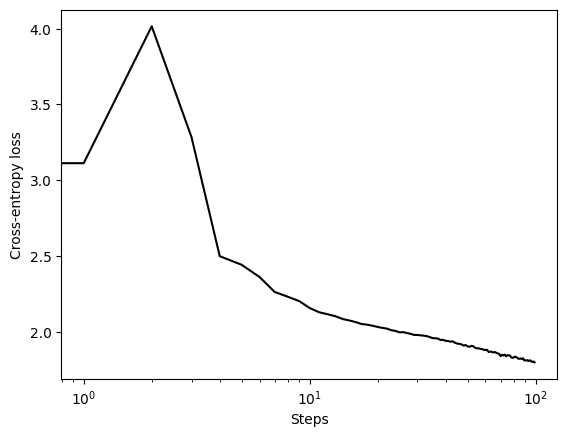

  1%|          | 119/10000 [01:21<1:52:49,  1.46it/s]


KeyboardInterrupt: 

In [1]:
class TrainConfig:
    max_depth = 26                          # God's Number
    batch_size_per_depth = 1000
    num_steps = 2000000
    learning_rate = 1e-3
    INTERVAL_PLOT, INTERVAL_SAVE = 10000, 100000
    ENABLE_FP16 = False                     # Set this to True if you want to train the model faster

import os
import random
import numpy as np
from contextlib import nullcontext
from tqdm import trange

import matplotlib.pyplot as plt
from cycler import cycler; plt.rcParams["axes.prop_cycle"] = cycler(color=["#000000", "#2180FE", "#EB4275"])
from IPython.display import clear_output

import torch
from torch import nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'device: {device}')
import random
import numpy as np
import torch
from enum import IntEnum
import torch.nn as nn

# U, D, L, R, B, F
class Move(IntEnum):
    """The moves in the faceturn metric. Not to be confused with the names of the facelet positions in class Facelet."""
    U1 = 0 # U(p) face clockwise
    U3 = 1 # U(p) face counter-clockwise
    D1 = 2 # D(p) face clockwise
    D3 = 3 # D(p) face counter-clockwise
    L1 = 4 # L(p) face clockwise
    L3 = 5 # L(p) face counter-clockwise
    R1 = 6 # R(p) face clockwise
    R3 = 7 # R(p) face counter-clockwise
    B1 = 8 # B(p) face clockwise
    B3 = 9 # B(p) face counter-clockwise
    F1 = 10 # F(p) face clockwise
    F3 = 11 # F(p) face counter-clockwise

move_dict = {
    Move.U1: "U",
    Move.U3: "U'",
    Move.R1: "R",
    Move.R3: "R'",
    Move.F1: "F",
    Move.F3: "F'",
    Move.D1: "D",
    Move.D3: "D'",
    Move.L1: "L",
    Move.L3: "L'",
    Move.B1: "B",
    Move.B3: "B'",
}

inverse_moves = {
    Move.U1 : Move.U3,
    Move.R1 : Move.R3,
    Move.F1 : Move.F3,
    Move.D1 : Move.D3,
    Move.L1 : Move.L3,
    Move.B1 : Move.B3,
    Move.U3 : Move.U1,
    Move.R3 : Move.R1,
    Move.F3 : Move.F1,
    Move.D3 : Move.D1,
    Move.L3 : Move.L1,
    Move.B3 : Move.B1
}

groups = {
    Move.U1 : "UD",
    Move.R1 : "LR",
    Move.F1 : "FB",
    Move.D1 : "UD",
    Move.L1 : "LR",
    Move.B1 : "FB",
    Move.U3 : "UD",
    Move.R3 : "LR",
    Move.F3 : "FB",
    Move.D3 : "UD",
    Move.L3 : "LR",
    Move.B3 : "FB",
}


def get_last_move(move_sequence):
    # select the last move in the sequence other than the null move. Return both the last move and the index to it
    # Otherwise, return the null move
    if len(move_sequence) == 0:
        raise ValueError("Empty move sequence")
    
    for move in (reversed(move_sequence)):
        return move

# Helper functions not provided:
def get_move_group(move):
    # Return the group number for the given move
    return groups[move]


def prevent_moves_pre(move_sequence, last_move, allowed_moves):
    temp = [move for move in move_sequence]
    subsequence = []
    last_group = get_move_group(last_move)
    
    for move in reversed(temp):
        if get_move_group(move) == last_group:
            subsequence.append(move)
        else:
            break
        
    pair_map = {}
    
    if last_group == "UD":
        pair_map = {Move.U1 : 0, Move.D1 : 0}
    elif last_group == "LR":
        pair_map = {Move.L1 : 0, Move.R1 : 0}
    else:
        pair_map = {Move.F1 : 0, Move.B1 : 0}
        
    for move in subsequence:
        if move in pair_map:
            pair_map[move] += 1
        if inverse_moves[move] in pair_map:
            pair_map[inverse_moves[move]] -= 1
            
    # can only have three situation for each group
    for i in pair_map:
        # xx & xxx => not allowed: x and x'
        if pair_map[i] % 4 == 2 or pair_map[i] % 4 == 3:
            if i in allowed_moves:
                allowed_moves.remove(i)
            if inverse_moves[i] in allowed_moves:
                allowed_moves.remove(inverse_moves[i])
        # x => not allowed: x'
        elif pair_map[i] % 4 == 1:
            if inverse_moves[i] in allowed_moves:
                allowed_moves.remove(inverse_moves[i])

    return allowed_moves


def get_allowed_moves(move_sequence):
    
    allowed_moves = list(Move)  # Start with all moves allowed
    
    if not move_sequence:
        return allowed_moves
    
    last_move = get_last_move(move_sequence)
    
    allowed_moves.remove(inverse_moves[last_move])
    
    allowed_moves = prevent_moves_pre(move_sequence, last_move, allowed_moves)
    return allowed_moves


class Cube:
    """Represent a cube on the facelet level with 54 colored facelets.
    
    Colors:

            0 0 0
            0 0 0
            0 0 0
    2 2 2   5 5 5   3 3 3   4 4 4
    2 2 2   5 5 5   3 3 3   4 4 4
    2 2 2   5 5 5   3 3 3   4 4 4
            1 1 1
            1 1 1
            1 1 1

    Order of stickers on each face:

    2   5   8
    1   4   7
    0   3   6

    Indices of state (each starting with 9*(n-1)):

                      |  2  5  8 |
                      |  1  4  7 |
                      |  0  3  6 |
             --------------------------------------------
             20 23 26 | 47 50 53 | 29 32 35 | 38 41 44
             19 22 25 | 46 49 52 | 28 31 34 | 37 40 43
             18 21 24 | 45 48 51 | 27 30 33 | 36 39 42
             --------------------------------------------           
                      | 11 14 17 |
                      | 10 13 16 |
                      | 9  12 15 |
    """
    
    def __init__(self):
        
        # Define initial and goal state
        self.reset()
        self.goal = np.arange(0, 9 * 6) // 9
        self.state = np.arange(0, 9 * 6) // 9
        
        self.sticker_replacement = {
            Move.U1:{0: 6, 1: 3, 2: 0, 3: 7, 5: 1, 6: 8, 7: 5, 8: 2, 20: 47, 23: 50, 26: 53, 29: 38, 32: 41, 35: 44, 38: 20, 41: 23, 44: 26, 47: 29, 50: 32, 53: 35},
            Move.D1:{9: 15, 10: 12, 11: 9, 12: 16, 14: 10, 15: 17, 16: 14, 17: 11, 18: 36, 21: 39, 24: 42, 27: 45, 30: 48, 33: 51, 36: 27, 39: 30, 42: 33, 45: 18, 48: 21, 51: 24},
            Move.L1:{0: 44, 1: 43, 2: 42, 9: 45, 10: 46, 11: 47, 18: 24, 19: 21, 20: 18, 21: 25, 23: 19, 24: 26, 25: 23, 26: 20, 42: 11, 43: 10, 44: 9, 45: 0, 46: 1, 47: 2},
            Move.R1:{6: 51, 7: 52, 8: 53, 15: 38, 16: 37, 17: 36, 27: 33, 28: 30, 29: 27, 30: 34, 32: 28, 33: 35, 34: 32, 35: 29, 36: 8, 37: 7, 38: 6, 51: 15, 52: 16, 53: 17},
            Move.B1:{2: 35, 5: 34, 8: 33, 9: 20, 12: 19, 15: 18, 18: 2, 19: 5, 20: 8, 33: 9, 34: 12, 35: 15, 36: 42, 37: 39, 38: 36, 39: 43, 41: 37, 42: 44, 43: 41, 44: 38},
            Move.F1:{0: 24, 3: 25, 6: 26, 11: 27, 14: 28, 17: 29, 24: 17, 25: 14, 26: 11, 27: 6, 28: 3, 29: 0, 45: 51, 46: 48, 47: 45, 48: 52, 50: 46, 51: 53, 52: 50, 53: 47}
        }
    
    def is_solved(self):
        return np.array_equal(self.state, self.goal)
    
    def reset(self):
        self.state = np.arange(0, 9 * 6) // 9        
        
    def perform_move(self, move):
        temp_values = {}
        for original, new in self.sticker_replacement[move].items():
            temp_values[original] = self.state[new]
                
            # Update the array in place
        for new, value in temp_values.items():
            self.state[new] = value
            
    def move(self, move: Move):
        if move == Move.U1:
            self.perform_move(Move.U1)
                    
        elif move == Move.U3:
            self.move(Move.U1)
            self.move(Move.U1)
            self.move(Move.U1)
            
        elif move == Move.R1:
            self.perform_move(Move.R1)
            
        elif move == Move.R3:
            self.perform_move(Move.R1)
            self.perform_move(Move.R1)
            self.perform_move(Move.R1)

        elif move == Move.F1:
            self.perform_move(Move.F1)
            
        elif move == Move.F3:
            self.perform_move(Move.F1)
            self.perform_move(Move.F1)
            self.perform_move(Move.F1)
            
        elif move == Move.D1:
            self.perform_move(Move.D1)
            
        elif move == Move.D3:
            self.perform_move(Move.D1)
            self.perform_move(Move.D1)
            self.perform_move(Move.D1)
            
        elif move == Move.L1:
            self.perform_move(Move.L1)
            
        elif move == Move.L3:
            self.perform_move(Move.L1)
            self.perform_move(Move.L1)
            self.perform_move(Move.L1)
            
        elif move == Move.B1:
            self.perform_move(Move.B1)
            
        elif move == Move.B3:
            self.perform_move(Move.B1)
            self.perform_move(Move.B1)
            self.perform_move(Move.B1)
        else:
            raise ValueError('Invalid move: ' + str(move))
                    
    def scrambler(self, scramble_length):
        """
        Generates a random scramble of given length and returns the cube state and scramble moves as a generator.
        Please note that index-based implementations (faster) follow commented lexical logics.
        """
        while True:
            # Reset the cube state, scramble, and return cube state and scramble moves
            self.reset()
            scramble = []

            for i in range(scramble_length):
                if i:
                    move = random.choice(get_allowed_moves(scramble))
                else: 
                    move = random.choice(list(Move))

                self.move(move)
                scramble.append(move)

                yield self.state, inverse_moves[move]        
          
env = Cube()

class LinearBlock(nn.Module):
    """
    Linear layer with ReLU and BatchNorm
    """
    def __init__(self, input_prev, embed_dim):
        super(LinearBlock, self).__init__()
        self.fc = nn.Linear(input_prev, embed_dim)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(embed_dim)

    def forward(self, inputs):
        x = inputs
        x = self.fc(x)
        x = self.relu(x)
        x = self.bn(x)
        return x

class ResidualBlock(nn.Module):
    """
    Residual block with two linear layers
    """
    def __init__(self, embed_dim):
        super(ResidualBlock, self).__init__()
        self.layers = nn.ModuleList([
            LinearBlock(embed_dim, embed_dim),
            LinearBlock(embed_dim, embed_dim)
        ])

    def forward(self, inputs):
        x = inputs
        for layer in self.layers:
            x = layer(x)
        x += inputs # skip-connection
        return x

class Model(nn.Module):
    """
    Fixed architecture following DeepCubeA.
    """
    def __init__(self, input_dim=324, output_dim=12):
        super(Model, self).__init__()
        self.input_dim = input_dim
        self.embedding = LinearBlock(input_dim, 5000)
        self.layers = nn.ModuleList([
            LinearBlock(5000,1000),
            ResidualBlock(1000),
            ResidualBlock(1000),
            ResidualBlock(1000),
            ResidualBlock(1000)
        ])
        self.output = nn.Linear(1000, output_dim)

    def forward(self, inputs):
        # int indices => float one-hot vectors
        x = nn.functional.one_hot(inputs, num_classes=6).to(torch.float)
        x = x.reshape(-1, self.input_dim)
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x)
        logits = self.output(x)
        return logits

model = Model()
model.to(device)

class ScrambleGenerator(torch.utils.data.Dataset):
    def __init__(
            self,
            num_workers=os.cpu_count(),
            max_depth=TrainConfig.max_depth,
            total_samples=TrainConfig.num_steps*TrainConfig.batch_size_per_depth
        ):
        self.num_workers = num_workers
        self.max_depth = max_depth
        self.envs = [Cube() for _ in range(num_workers)]
        self.generators = [env.scrambler(self.max_depth) for env in self.envs]

        self.total_samples = total_samples

    def __len__(self):
        return self.total_samples

    def __getitem__(self, i):
        ''' generate one scramble, consisting of `self.max_depth` data points '''
        worker_idx = i % self.num_workers
        X = np.zeros((self.max_depth, 54), dtype=int)
        y = np.zeros((self.max_depth,), dtype=int)
        for j in range(self.max_depth):
            state, last_move = next(self.generators[worker_idx])
            X[j, :] = state
            y[j] = last_move
        return X, y

dataloader = torch.utils.data.DataLoader(
    ScrambleGenerator(),
    num_workers=os.cpu_count(),
    batch_size=TrainConfig.batch_size_per_depth,
)
def plot_loss_curve(h):
    fig, ax = plt.subplots(1, 1)
    ax.plot(h)
    ax.set_xlabel("Steps")
    ax.set_ylabel("Cross-entropy loss")
    ax.set_xscale("log")
    plt.savefig("loss_curve.png")

def train(model, dataloader):
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=TrainConfig.learning_rate)
    g = iter(dataloader)
    h = []
    ctx = torch.cuda.amp.autocast(dtype=torch.float16) if TrainConfig.ENABLE_FP16 else nullcontext()

    for i in trange(1, TrainConfig.num_steps + 1):
        batch_x, batch_y = next(g)
        batch_x, batch_y = batch_x.reshape(-1, 54).to(device), batch_y.reshape(-1).to(device)

        with ctx:
            pred_y = model(batch_x)
            loss = loss_fn(pred_y, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        h.append(loss.item())
        if TrainConfig.INTERVAL_PLOT and i % TrainConfig.INTERVAL_PLOT == 0:            
            clear_output()
            plot_loss_curve(h)
            
        if TrainConfig.INTERVAL_SAVE and i % TrainConfig.INTERVAL_SAVE == 0:
            torch.save(model.state_dict(), f"{i}steps_reversed.pth")
            print("Model saved.")
    print(f"Trained on data equivalent to {TrainConfig.batch_size_per_depth * TrainConfig.num_steps} solves.")
    print(f"Final loss: {h[-1]}")
    return model

model = train(model, dataloader)
# save the model
torch.save(model.state_dict(), "reversed_trained_model.pth")